In [ ]:
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from PIL import Image
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
from einops import rearrange
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer import TexturesUV
from rendering import init_renderer, rasterize_mesh
import torchvision.transforms as transforms

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

In [ ]:
device = torch.device("cuda:0")
meshes = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

In [3]:
R, T = look_at_view_transform(dist=2, azim=150, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

# Set up Renderer
renderer = init_renderer(cameras)

# Rasterize Mesh
fragments, depth_map = rasterize_mesh(renderer, meshes)

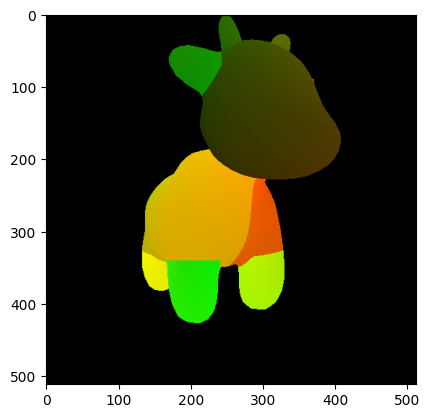

In [4]:
# get UV coordinates for each pixel
texture: TexturesUV = meshes.textures
texture_map = texture.maps_list()[0]
verts_uvs = texture.verts_uvs_list()[0]
faces_uvs = texture.faces_uvs_list()[0]

# (F, 3, 2) for each face, for each vert a uv coord
face_vert_uvs = verts_uvs[faces_uvs]

# interpolate uv coords to obtain pixel-uvs
pixel_uvs = interpolate_face_attributes(
    fragments.pix_to_face,
    fragments.bary_coords,
    face_vert_uvs
)

# (H, W, 2)
pixel_uvs = rearrange(pixel_uvs, '1 h w 1 d -> h w d')

# add empty channel to make it RGB for visualization purposes
pixel_uvs_rgb = torch.cat([pixel_uvs, torch.zeros(pixel_uvs.shape[0], pixel_uvs.shape[1], 1).to(pixel_uvs)], dim=2)
plt.imshow(pixel_uvs_rgb.cpu())

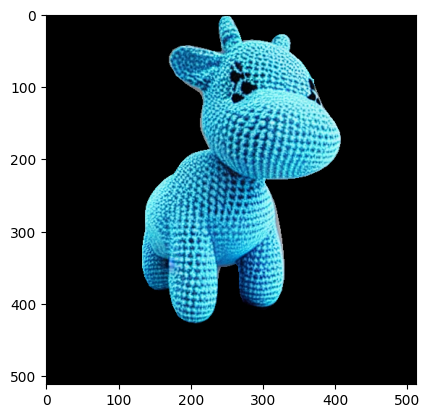

In [5]:
from util import swap_channel_pos

# values that 
mask = depth_map != 0
plt.imshow(mask.cpu())

image = Image.open('data/example/view.png')
image_tensor = swap_channel_pos(to_tensor(image))

image_masked = image_tensor
image_tensor[~mask] = 0

plt.imshow(image_tensor)

In [8]:
# uv coords of each pixel that is not masked
projected_uvs = pixel_uvs[mask]
indices = torch.nonzero(mask)

In [ ]:
# scale projected uvs to be actual texel values
uv_size = 1024
texture_locations_y = ((1 - projected_uvs[:, 1]) * (uv_size - 1)).to(torch.long)
texture_locations_x = (projected_uvs[:, 0] * (uv_size - 1)).to(torch.long)

In [ ]:
new_texture = texture_map.clone()

In [ ]:
image_masked[indices].shape


In [ ]:
from torch import Tensor

def uv_coords_to_pixel_coords(uvs: Tensor, uv_size):
    us = uvs[:, 1]
    vs = uvs[:, 0]

    texture_ys = (1 - us) * (uv_size - 1)
    texture_xs = vs * (uv_size - 1)

    return texture_xs, texture_ys

xs, ys = uv_coords_to_pixel_coords(projected_uvs, 1024)

In [ ]:

from einops import repeat

K = renderer.rasterizer.raster_settings.faces_per_pixel

texture_values = rearrange(to_tensor(image), 'c h w -> h w c')
texture_values = repeat(texture_values, 'h w c -> k 4 h w c', k=K)

mask_expended = repeat(mask, 'h w -> k 4 h w', k=K)


In [ ]:
bary_coords = fragments.bary_coords[0, :, :, 0, :]

plt.imshow(bary_coords.cpu())

# plt.imshow(fragments.pix_to_face[0, :, :, 0].cpu())

In [ ]:
pixel_us = torch.Tensor([0.2, 0.34, 0.5])
ref_img = torch.Tensor([1, 2, 3])

texture_size = 100
texture_1d = torch.zeros(texture_size)

texture_indices_float = ((1 - pixel_us) * (texture_size - 1))
texture_indices = torch.floor(texture_indices_float).to(torch.long)
texture_1d[texture_indices] = ref_img

plt.imshow(texture_1d.unsqueeze(0), extent=[1,0,0,0.1])
plt.yticks([])
plt.xticks([0.2, 0.34, 0.5])
# plt.axis('off')
